In [1]:
import cv2
import requests
from PIL import Image
import torch
import numpy as np

from matplotlib import pyplot as plt

from transformers import OwlViTProcessor, OwlViTForObjectDetection

2024-05-16 18:45:27.075733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
obj_detector = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

/home/nikhiljoshi/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
VIDEO_FILEPATH = 'testdata/20210111_DML2387.mp4'

In [24]:
video = cv2.VideoCapture(VIDEO_FILEPATH)
if not video.isOpened():
    raise RuntimeError('Video opening failed')

In [25]:
interesting_images = []
count = 0
step_size = 10
while video.isOpened():
    video.set(cv2.CAP_PROP_POS_FRAMES, count)
    count += step_size
    ret, frame = video.read()
    if not ret: break

    h, w, c = frame.shape
    frame = cv2.resize(frame, (w//4, h//4))
    frame = Image.fromarray(frame)
    texts = [["a photo of a slate with text", "a photo of a white slate"]]
    inputs = processor(text=texts, images=frame, return_tensors="pt")
    outputs = obj_detector(**inputs)
    target_sizes = torch.Tensor([frame.size[::-1]])
    # Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
    text = texts[0]
    boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]
    for box, score, label in zip(boxes, scores, labels):
        box = [round(i, 2) for i in box.tolist()]
        conf = round(score.item(), 3)
        if conf < 0.1: continue

        print(f"Detected {text[label]} with confidence {conf} at location {box}")
        frame = np.array(frame)
        mask = np.zeros(frame.shape[:2], dtype="uint8")
        cv2.rectangle(mask, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 255, -1)
        #cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0))
        interesting_images.append((cv2.bitwise_and(frame, frame, mask=mask), conf))
        if conf > 0.8:
            print('Found one frame with strong confidence. will stop.')
            video.release()
    if len(interesting_images) > 2: break

video.release()
cv2.destroyAllWindows()

Detected a photo of a slate with text with confidence 0.119 at location [290.64, 371.51, 600.03, 541.19]
Detected a photo of a slate with text with confidence 0.106 at location [315.77, 308.47, 582.75, 503.71]
Detected a photo of a slate with text with confidence 0.109 at location [288.43, 279.08, 596.18, 513.01]


In [26]:
s = sorted(interesting_images, key=lambda t: t[1])

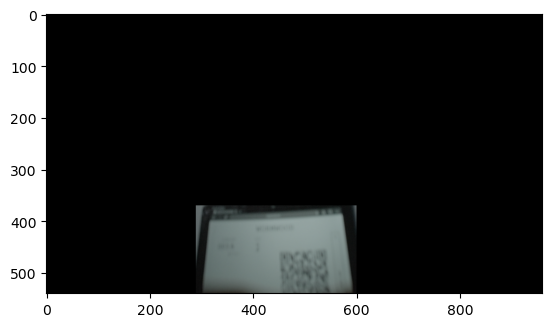

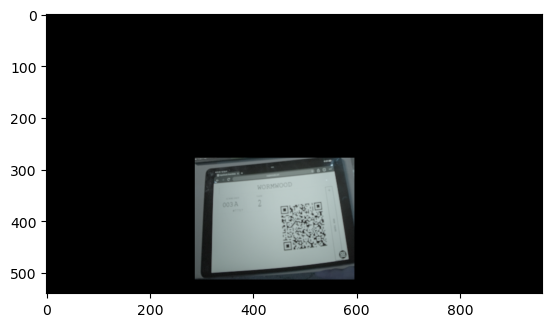

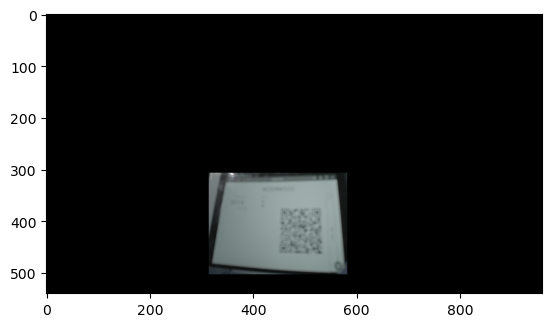

In [27]:
# Print the masked out images.
for t in reversed(s):
    plt.imshow(t[0])
    plt.show()